In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from model.BayesExplainer import BayesExplainer
from model.samplers.BetaBernoulliSampler import BetaBernoulliSampler
from model.samplers.NFSampler import NFSampler

from tqdm import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_features)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

/var/folders/ss/d51rr5hd6t35mk152_9djsym0000gn/T/ipykernel_43467/3063853731.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
Loss -> 0.05333: 100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]


Net(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=1433, bias=True)
)

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 496.48it/s]


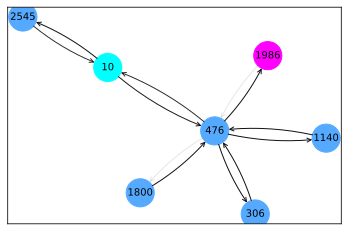

In [2]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

  0%|          | 0/2500 [00:00<?, ?it/s]/Users/shalinpatel/virtualenv/GCN-Integration/lib/python3.9/site-packages/pyro/util.py:286: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'y_hat'}
  warnings.warn(
Loss -> 6.6707: 100%|██████████| 2500/2500 [00:18<00:00, 132.16it/s] 


<AxesSubplot:>

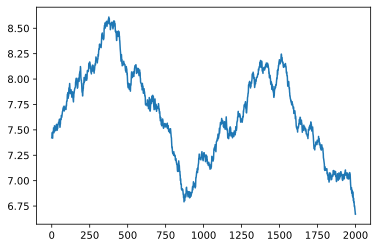

In [3]:
node_idx = 10
k = 2
sampler = BetaBernoulliSampler("beta_bernoulli", 2.0, 10.0)
explainer = BayesExplainer(model, sampler, node_idx, k, x, edge_index)
avgs = explainer.train(epochs=2500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

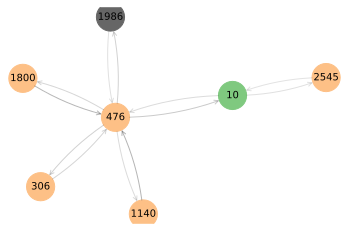

In [4]:
edge_mask = explainer.edge_mask()
ax, G = BayesExplainer.visualize_subgraph(node_idx, edge_index, edge_mask, data.y, k)
plt.show()

In [5]:
edge_mask

tensor([0.1409, 0.1239, 0.1665, 0.2100, 0.1823, 0.1444, 0.1605, 0.1770, 0.2899,
        0.2836, 0.1215, 0.1144], grad_fn=<DivBackward0>)

  0%|          | 0/2500 [00:00<?, ?it/s]/Users/shalinpatel/virtualenv/GCN-Integration/lib/python3.9/site-packages/pyro/util.py:293: UserWarning: Found vars in model but not guide: {'m', 'y_sample'}
  warnings.warn(
Loss -> 15.9867: 100%|██████████| 2500/2500 [02:01<00:00, 20.58it/s]


<AxesSubplot:>

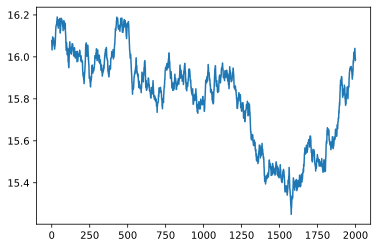

In [6]:
node_idx = 10
k = 2
splines = 8
sampler = NFSampler("nf_sampler", explainer.N, splines, True, 1e-5, 1.25, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, edge_index)
avgs = explainer.train(epochs=2500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

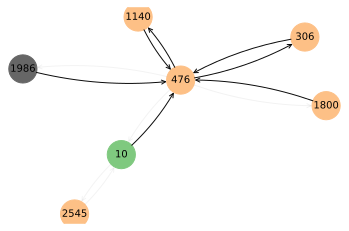

In [7]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, data.y, k)
plt.show()

In [8]:
edge_mask

tensor([0.9510, 0.0503, 0.9510, 0.0495, 0.9512, 0.9519, 0.0543, 0.0488, 0.9509,
        0.9516, 0.9515, 0.0487], grad_fn=<MeanBackward1>)